# Rossman Kaggle Mini-Competition

Forecast sales using store, promotion, and competitor data

This is a Kaggle competition and can be found [here](https://www.kaggle.com/competitions/rossmann-store-sales/overview)

# Libraries

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Functions

In [2]:
def mean_encode(df: pd.DataFrame, feature: str, target: str):
    """
    df: dataframe with "feature" and "target" columns
    feature: feature to transform
    target: target variable
    """
    new_col_name = feature + "_mean"
    df_enc = (
        # select columns
        df.loc[:, [feature, target]]
        # group by feature
        .groupby(feature)
        # aggregate over feature using target mean
        .agg(tmp_name=(target, np.mean))
        # index (i.e., feature categories) as a column
        .reset_index()
        # rename the column with the aggregated means
        .rename(columns={"tmp_name":new_col_name})
    )

    # merge: add the new column with the aggregated mean from
    # "df_enc" back into "df"
    df_merged = pd.merge(df, df_enc, how="left", on=feature)

    return df_merged


def mean_encode_2(df: pd.DataFrame, feature1: str, feature2: str, target: str):
    """
    Same as "mean_encode" but with 2 features.
    df: dataframe with "feature" and "target" columns
    feature: feature to transform
    target: target variable
    """
    new_col_name = feature1 + feature2 + "_mean"
    df_enc = (
        # select columns
        df.loc[:, [feature1, feature2, target]]
        # group by feature
        .groupby([feature1, feature2])
        # aggregate over feature using target mean
        .agg(tmp_name = (target, np.mean))
        # index (i.e., feature categories) as a column
        .reset_index()
        # rename the column with the aggregated means
        .rename(columns={"tmp_name":new_col_name})
        )

    # merge: add the new column with the aggregated mean from
    # "df_enc" back into "df"
    df_merged = pd.merge(df, df_enc, how="left", on=[feature1, feature2])

    return df_merged


def convert_to_others(df: pd.DataFrame, feature: str, N_counts: int):
    """
    df: data frame
    feature: feature to transform
    N_counts: categories with less than "N_counts" counts are converted to "others" 
    """

    df_count = (
        df
        .groupby(feature)[feature]
        .value_counts()
        .reset_index()
    )

    # Select the categories with less than N_counts
    df_other = df_count.loc[df_count["count"] < N_counts, feature]

    # Name for the new column with some categories converted to "others"
    new_col_name = feature + "_others"

    # Copy original column
    df[new_col_name] = df[feature]
    # Categories with less than "N_counts" counts (this info is #
    # stored in the data frame "df_other") are set to "others"
    df.loc[df[feature].isin(df_other), [new_col_name]] = "others"

    return df


def print_NA_info(df: pd.DataFrame, feature:str):
    print(f"Number of unique values: {len(df[feature].unique())}")
    print(f"Unique values: {df[feature].unique()}")
    print(f"Shape train data: {df.shape}")
    na_per = ((df[feature].isna().sum() / len(df[feature])) * 100).round(2)
    print(f"The percentage of NA is: {na_per}%")

# Load data

In [3]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)


dataset_path = Path().absolute() / "data"

# Load dataset
filename = "store.csv"
store = load_ds(dataset_path, filename)

# Load dataset
filename = "train.csv"
train = load_ds(dataset_path, filename)

/tmp/ipykernel_26222/3563638345.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path / filename)


In [4]:
print(f"Shape store data set: {store.shape}")
print(f"Shape train data set: {train.shape}")

Shape store data set: (1115, 10)
Shape train data set: (637774, 9)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637774 entries, 0 to 637773
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           637774 non-null  object 
 1   Store          618473 non-null  float64
 2   DayOfWeek      618757 non-null  float64
 3   Sales          618747 non-null  float64
 4   Customers      618683 non-null  float64
 5   Open           618588 non-null  float64
 6   Promo          618580 non-null  float64
 7   StateHoliday   618520 non-null  object 
 8   SchoolHoliday  618437 non-null  float64
dtypes: float64(7), object(2)
memory usage: 43.8+ MB


In [6]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,618473.000000,618757.000000,618747.000000,618683.000000,618588.000000,618580.000000,618437.000000
mean,558.105623,3.994914,5668.015834,628.909831,0.829167,0.370447,0.173253
std,321.885545,1.997485,3809.655137,463.786905,0.376363,0.482925,0.378466
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.000000,2.000000,3640.000000,397.000000,1.000000,0.000000,0.000000
50%,558.000000,4.000000,5625.000000,604.000000,1.000000,0.000000,0.000000
75%,837.000000,6.000000,7714.000000,833.000000,1.000000,1.000000,0.000000
max,1115.000000,7.000000,38037.000000,7388.000000,1.000000,1.000000,1.000000


In [7]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [8]:
train.Store

0         1115.0
1          379.0
2          378.0
3          377.0
4          376.0
           ...  
637769     752.0
637770     753.0
637771     754.0
637772     755.0
637773     751.0
Name: Store, Length: 637774, dtype: float64

In [9]:
store.Store

0          1
1          2
2          3
3          4
4          5
        ... 
1110    1111
1111    1112
1112    1113
1113    1114
1114    1115
Name: Store, Length: 1115, dtype: int64

In [10]:
train_store = train.merge(store, on="Store")

In [11]:
train_store.shape

(618473, 18)

In [12]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618473 entries, 0 to 618472
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date                       618473 non-null  object 
 1   Store                      618473 non-null  float64
 2   DayOfWeek                  600036 non-null  float64
 3   Sales                      600028 non-null  float64
 4   Customers                  599957 non-null  float64
 5   Open                       599832 non-null  float64
 6   Promo                      599791 non-null  float64
 7   StateHoliday               599873 non-null  object 
 8   SchoolHoliday              599686 non-null  float64
 9   StoreType                  618473 non-null  object 
 10  Assortment                 618473 non-null  object 
 11  CompetitionDistance        616838 non-null  float64
 12  CompetitionOpenSinceMonth  422043 non-null  float64
 13  CompetitionOpenSinceYear   42

In [13]:
(train_store.isna().sum() / train_store.shape[0]).reset_index()

,index,0
0,Date,0.000000
1,Store,0.000000
2,DayOfWeek,0.029811
3,Sales,0.029823
4,Customers,0.029938
5,Open,0.030140
6,Promo,0.030207
7,StateHoliday,0.030074
8,SchoolHoliday,0.030376
9,StoreType,0.000000


Remove the rows where `Sales` is NA or 0

In [14]:
train_store = train_store.loc[~train_store.Sales.isna(), :]
train_store = train_store.loc[train_store.Sales != 0, :]

In [15]:
(train_store.isna().sum() / train_store.shape[0]).reset_index()

,index,0
0,Date,0.000000
1,Store,0.000000
2,DayOfWeek,0.029776
3,Sales,0.000000
4,Customers,0.030126
5,Open,0.030178
6,Promo,0.030182
7,StateHoliday,0.030221
8,SchoolHoliday,0.030345
9,StoreType,0.000000


In [16]:
train_store.iloc[:,:8].head(10)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday
1,2013-01-02,1115.0,3.0,3697.0,305.0,1.0,0.0,0
2,2013-01-03,1115.0,4.0,4297.0,300.0,1.0,0.0,0
3,2013-01-04,1115.0,5.0,4540.0,326.0,1.0,0.0,0
4,2013-01-05,1115.0,6.0,4771.0,339.0,1.0,0.0,0
6,2013-01-07,1115.0,1.0,6905.0,471.0,1.0,1.0,0
7,2013-01-08,1115.0,2.0,5243.0,341.0,1.0,1.0,0
8,2013-01-09,1115.0,3.0,4649.0,324.0,1.0,1.0,0
9,2013-01-10,1115.0,4.0,5007.0,339.0,1.0,1.0,0
10,2013-01-11,1115.0,5.0,5142.0,351.0,1.0,1.0,0
11,2013-01-12,1115.0,6.0,4497.0,350.0,1.0,0.0,NaN


In [17]:
train_store.iloc[:,8:13].head(10)

,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth
1,1.0,d,c,5350.0,NaN
2,1.0,d,c,5350.0,NaN
3,1.0,d,c,5350.0,NaN
4,1.0,d,c,5350.0,NaN
6,1.0,d,c,5350.0,NaN
7,1.0,d,c,5350.0,NaN
8,1.0,d,c,5350.0,NaN
9,1.0,d,c,5350.0,NaN
10,1.0,d,c,5350.0,NaN
11,0.0,d,c,5350.0,NaN


In [18]:
train_store.iloc[:,13:].head(10)

,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
2,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
3,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
4,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
6,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
7,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
8,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
9,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
10,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
11,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


# EDA

## Sales

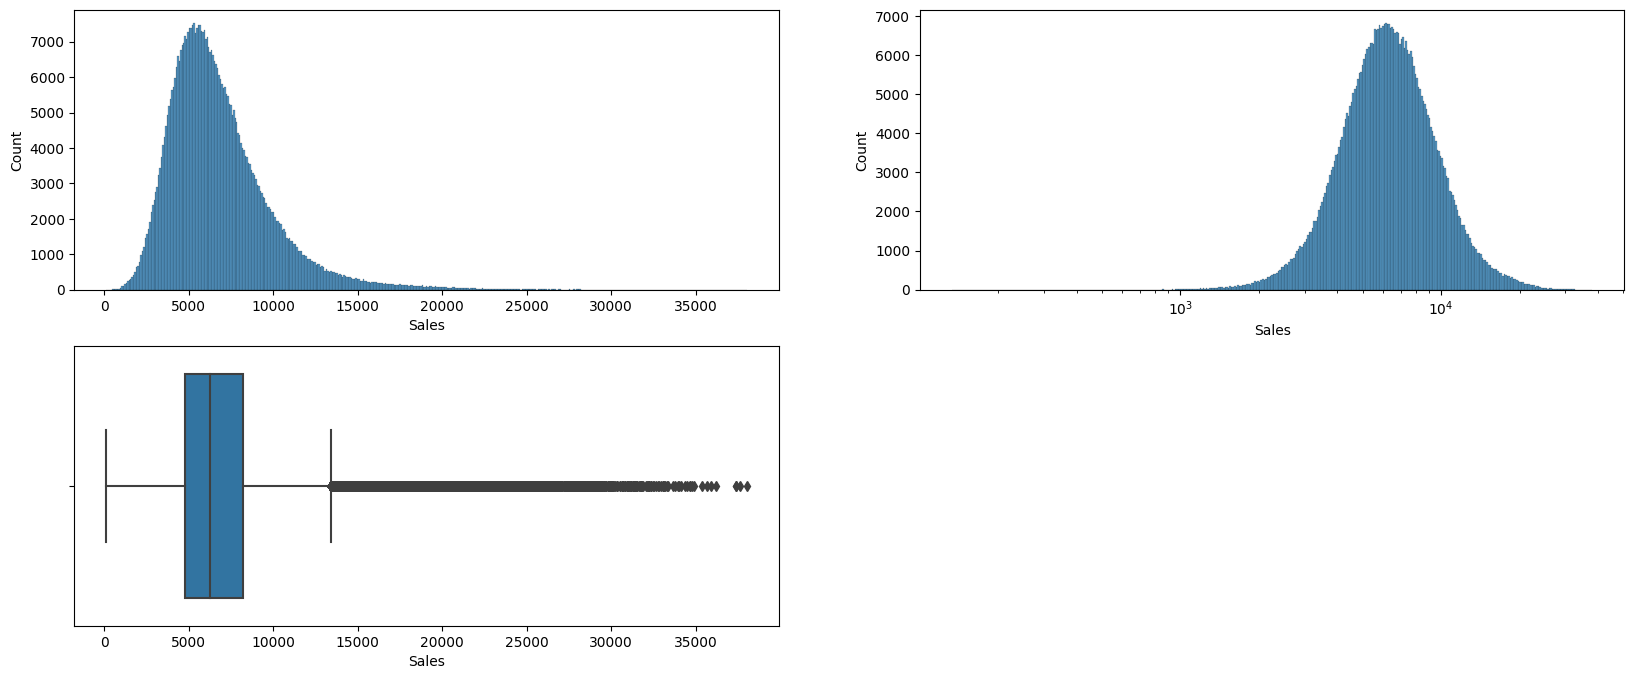

In [19]:
plt.figure(figsize=(20, 8))

plt.subplot(2, 2, 1)
sns.histplot(train_store, x="Sales")

plt.subplot(2, 2, 2)
sns.histplot(train_store, x="Sales", log_scale=True)

plt.subplot(2, 2, 3)
sns.boxplot(x="Sales", data=train_store)

plt.show()

## Date

In [20]:
date2 = pd.to_datetime(train_store["Date"], format="%Y-%m-%d") # format="%d/%m/%Y"
month = date2.dt.month
year = date2.dt.year
day = date2.dt.day

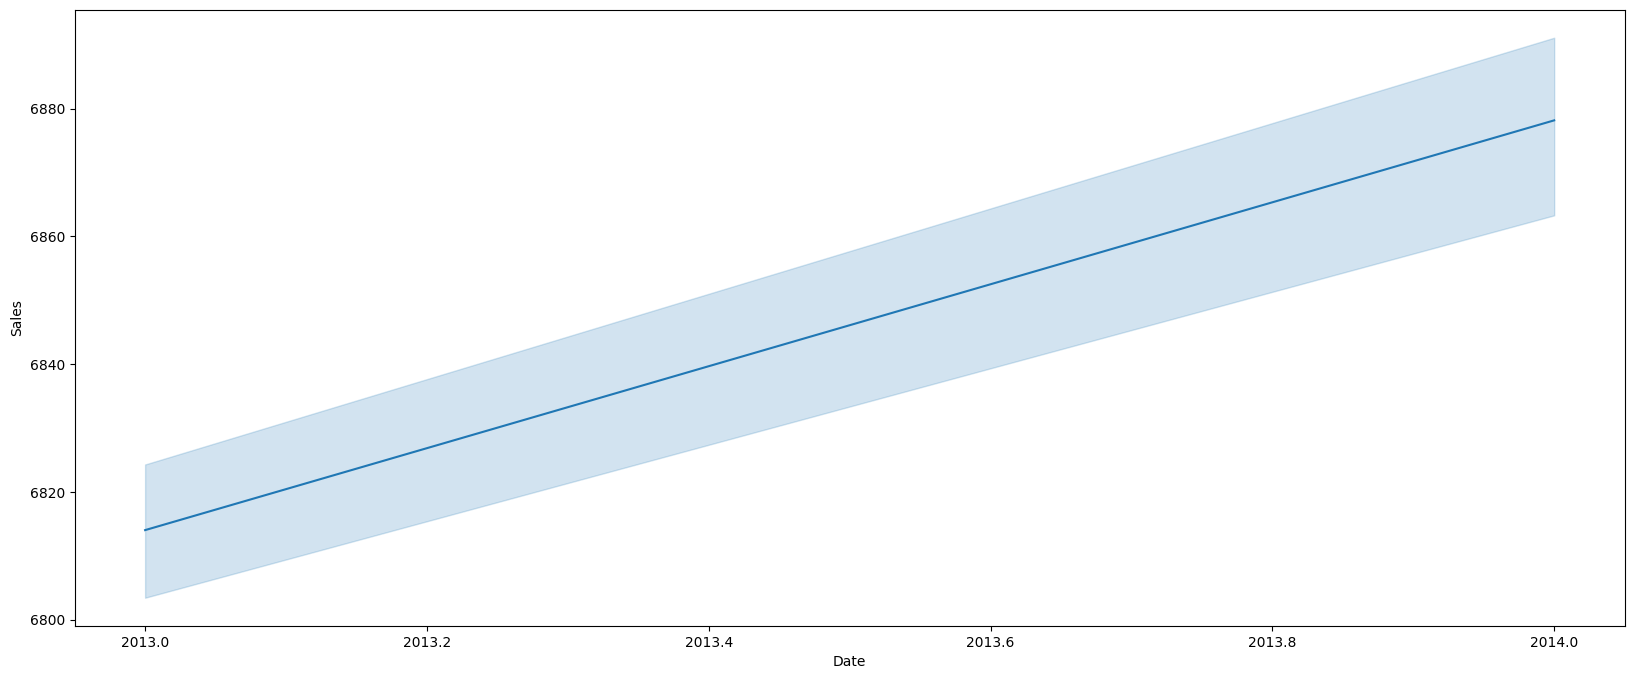

In [21]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=year, y="Sales", data=train_store)
# sns.scatterplot(x=month, y="Sales", data=train_store)
plt.show()

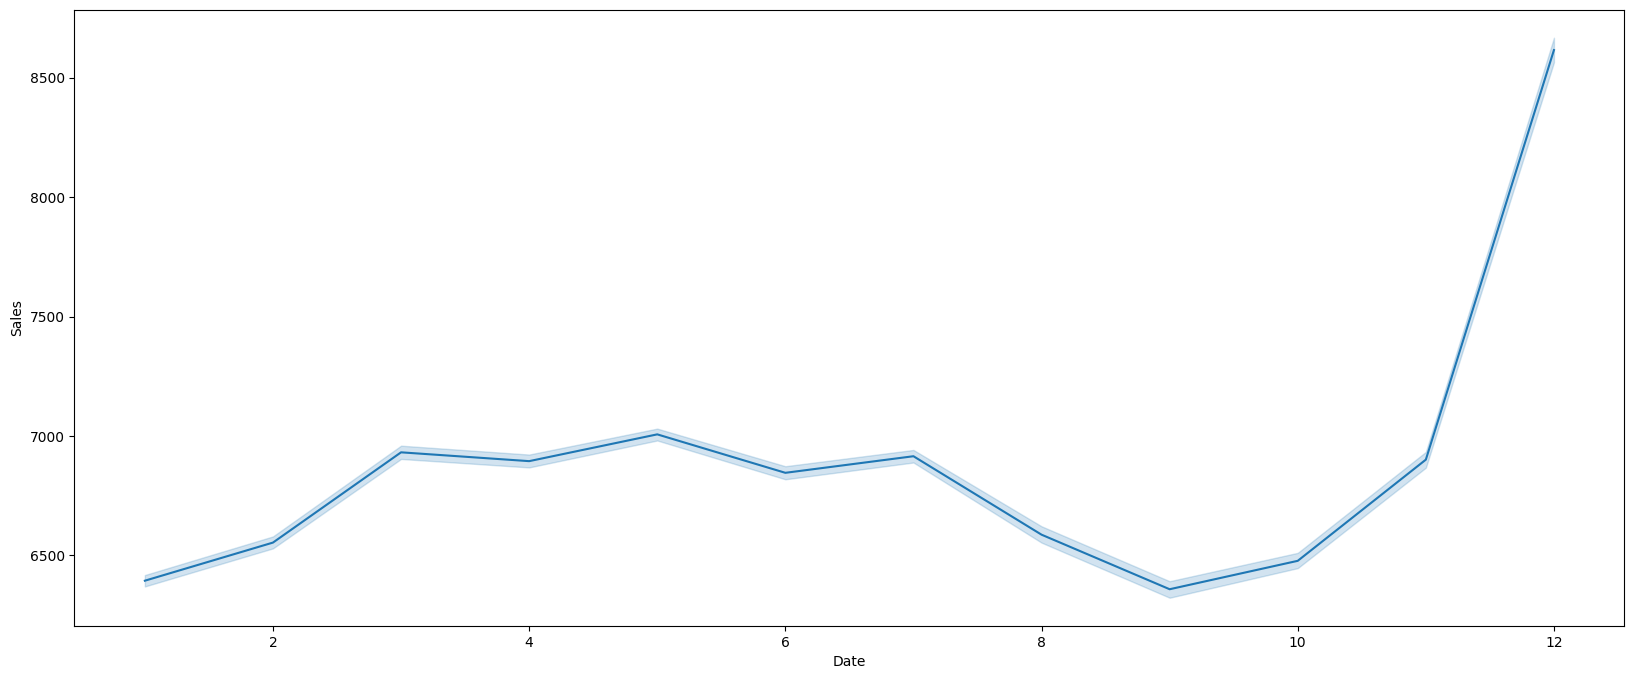

In [22]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=month, y="Sales", data=train_store)
# sns.scatterplot(x=month, y="Sales", data=train_store)
plt.show()

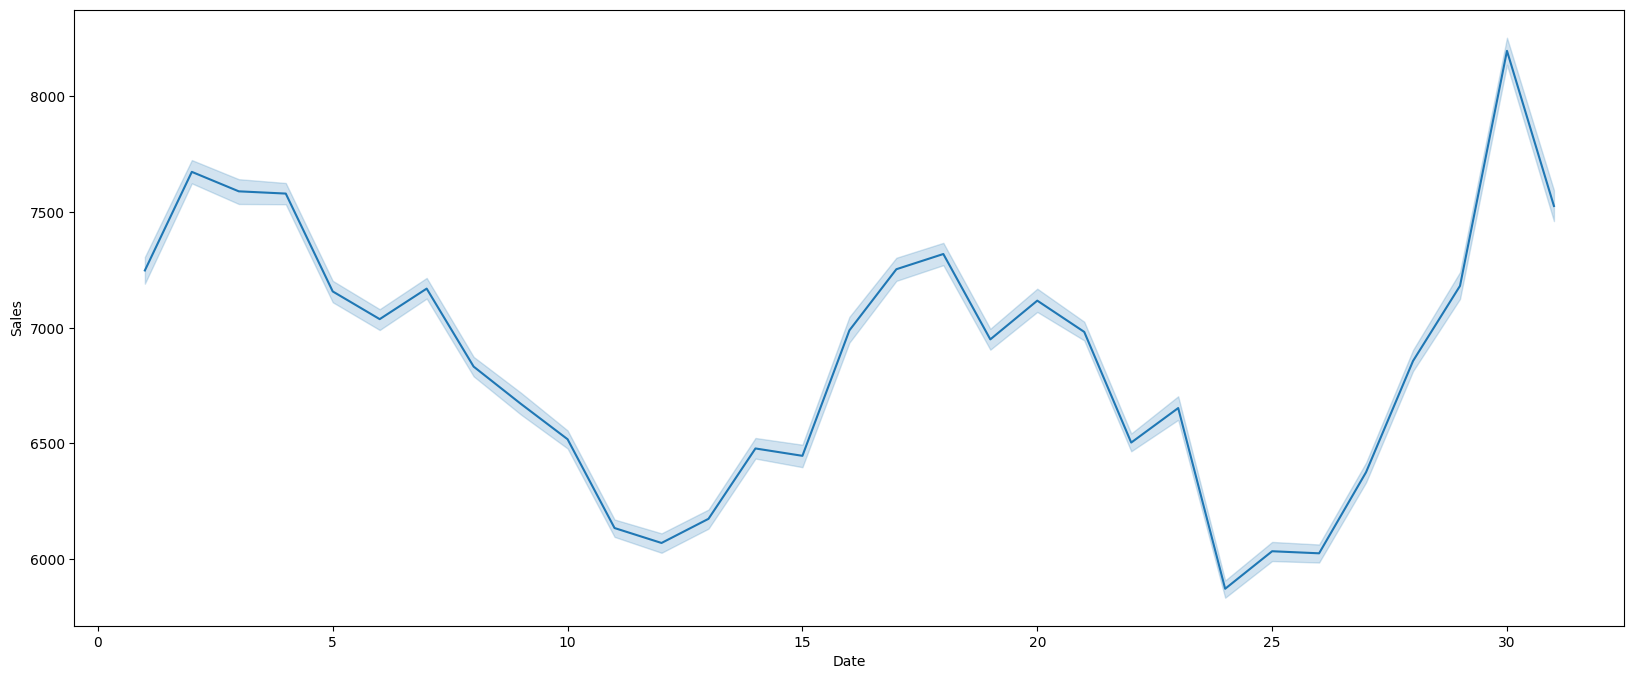

In [23]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=day, y="Sales", data=train_store)
plt.show()

# Store

In [24]:
print(f"Number of unique address: {len(train_store.Store.unique())}")
print(f"Shape train data: {train_store.shape}")

# len(train_store.Store.unique())

Number of unique address: 1115
Shape train data: (497376, 18)


In [25]:
df_tmp = mean_encode(train_store, "Store", "Sales")

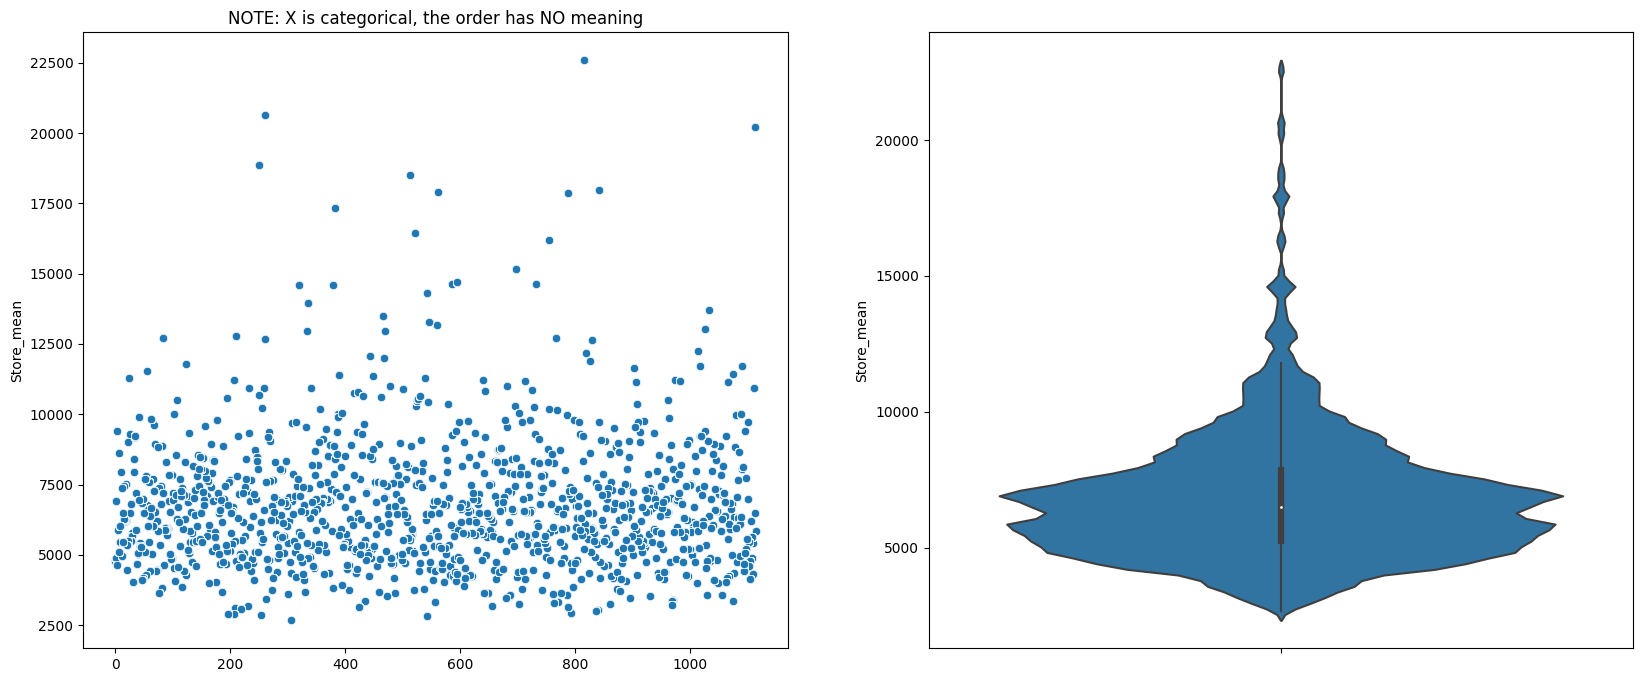

In [26]:
x_plot = pd.Categorical(df_tmp.Store).codes

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_tmp, x=x_plot, y="Store_mean")
plt.title("NOTE: X is categorical, the order has NO meaning")

plt.subplot(1, 2, 2)
sns.violinplot(data=df_tmp, y="Store_mean")

plt.show()

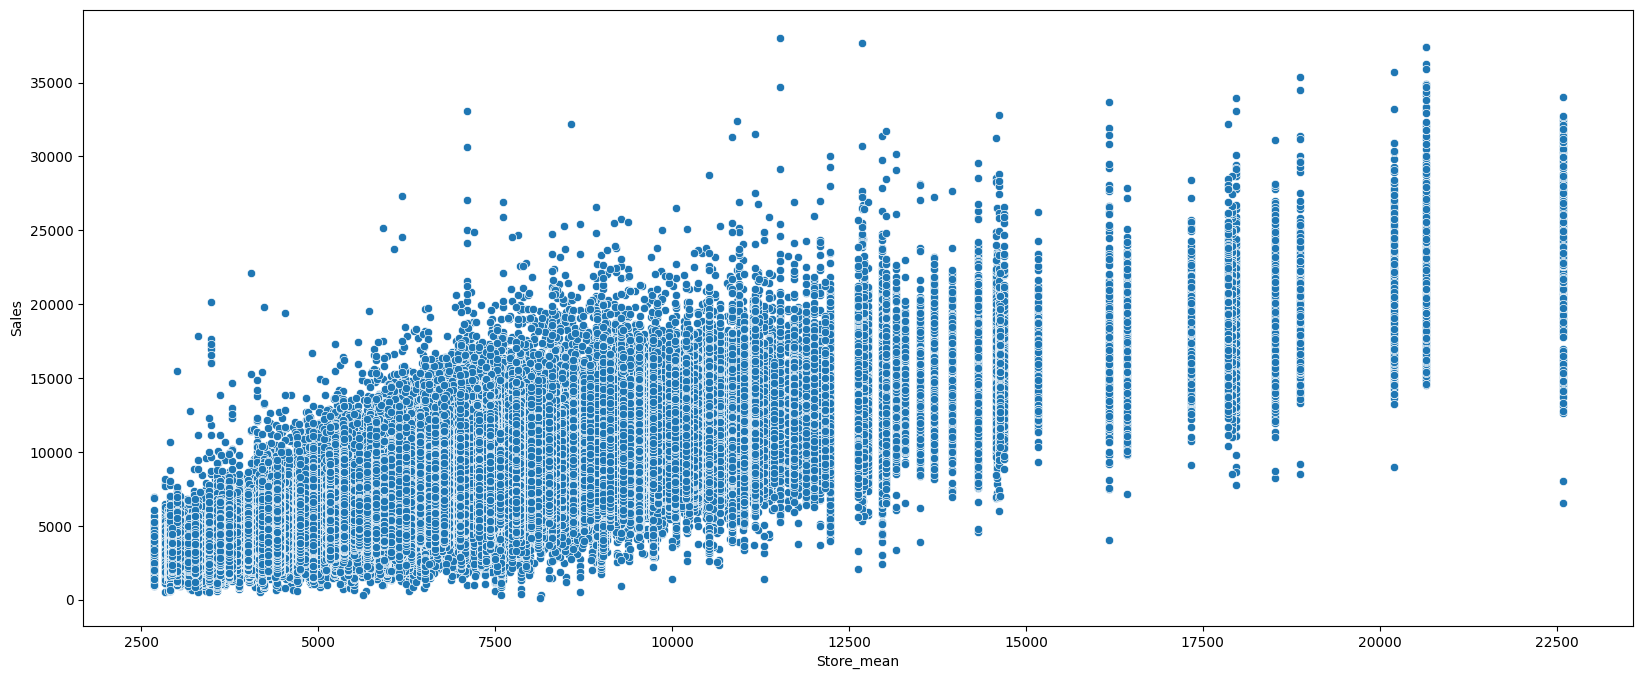

In [27]:
plt.figure(figsize=(20, 8))
# sns.lineplot(x="Store_mean", y="Sales", data=df_tmp)
sns.scatterplot(x="Store_mean", y="Sales", data=df_tmp)
plt.show()

We will use `mean encoding` for `Store`

# DayOfWeek

In [28]:
train_store.DayOfWeek

1         3.0
2         4.0
3         5.0
4         6.0
6         1.0
         ... 
618467    3.0
618468    4.0
618469    5.0
618470    6.0
618472    1.0
Name: DayOfWeek, Length: 497376, dtype: float64

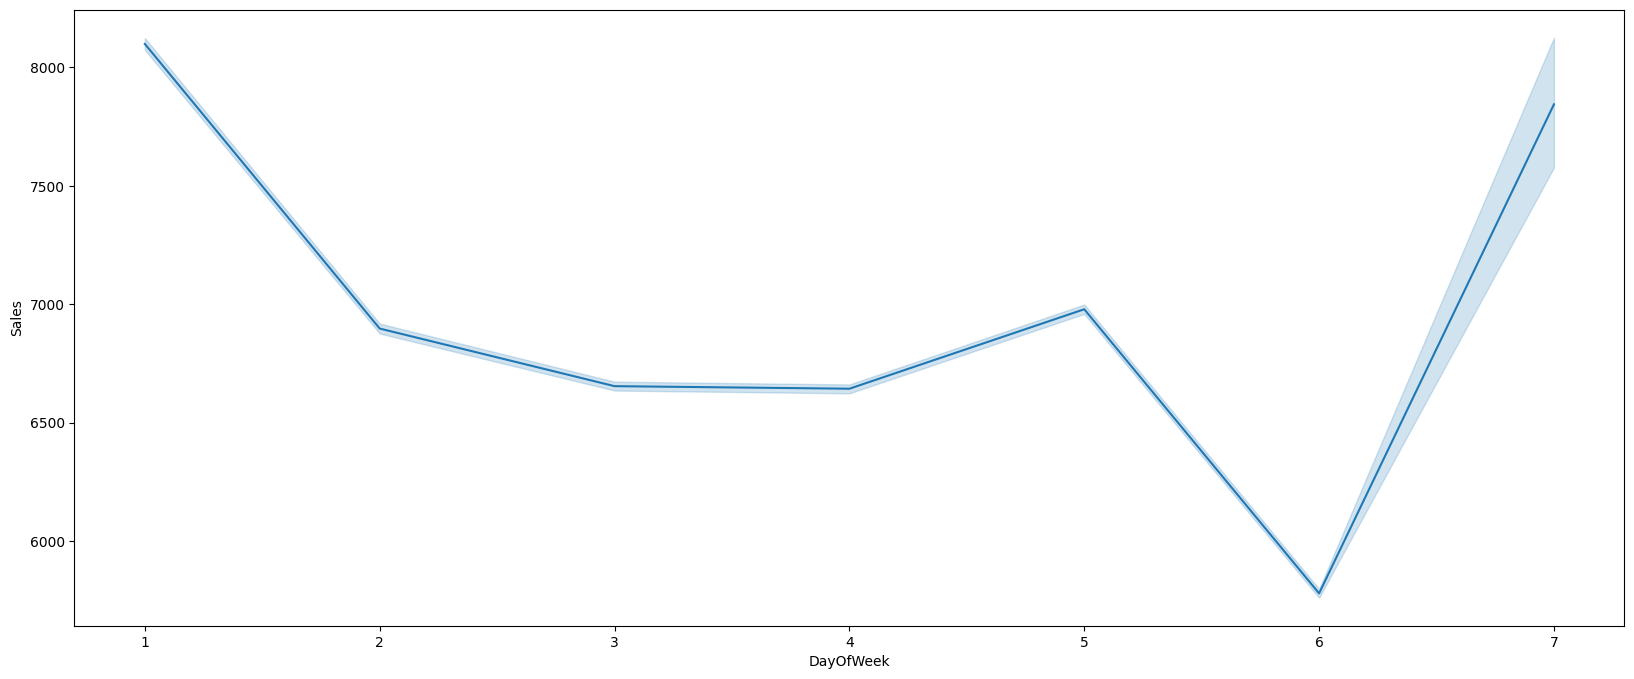

In [29]:
plt.figure(figsize=(20, 8))
sns.lineplot(x="DayOfWeek", y="Sales", data=train_store)
plt.show()

In [30]:
df_tmp = mean_encode(train_store, "DayOfWeek", "Sales")

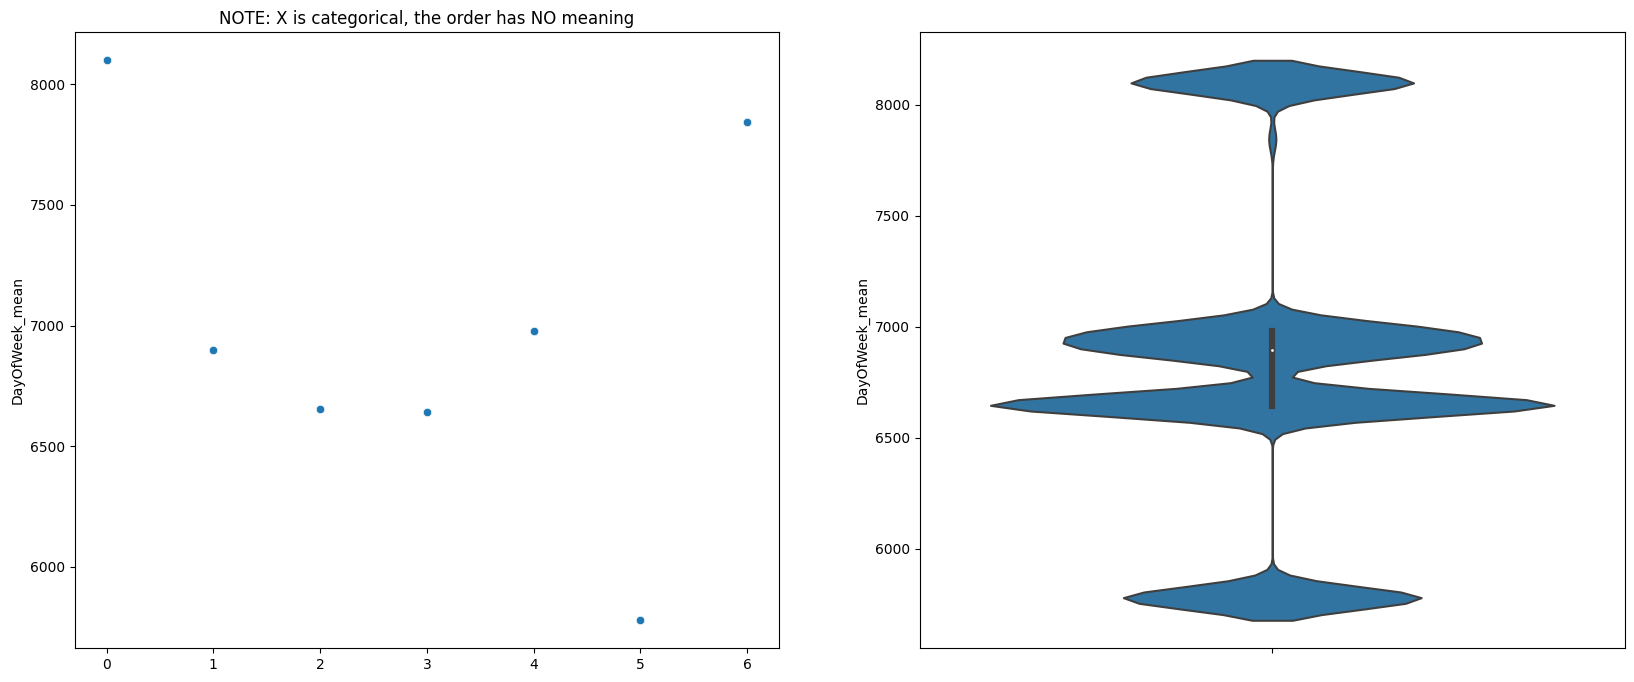

In [31]:
x_plot = pd.Categorical(df_tmp.DayOfWeek).codes

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_tmp, x=x_plot, y="DayOfWeek_mean")
plt.title("NOTE: X is categorical, the order has NO meaning")

plt.subplot(1, 2, 2)
sns.violinplot(data=df_tmp, y="DayOfWeek_mean")

plt.show()

# Customers

In [32]:
train_store.Customers

1          305.0
2          300.0
3          326.0
4          339.0
6          471.0
           ...  
618467     562.0
618468     480.0
618469     591.0
618470     716.0
618472    1119.0
Name: Customers, Length: 497376, dtype: float64

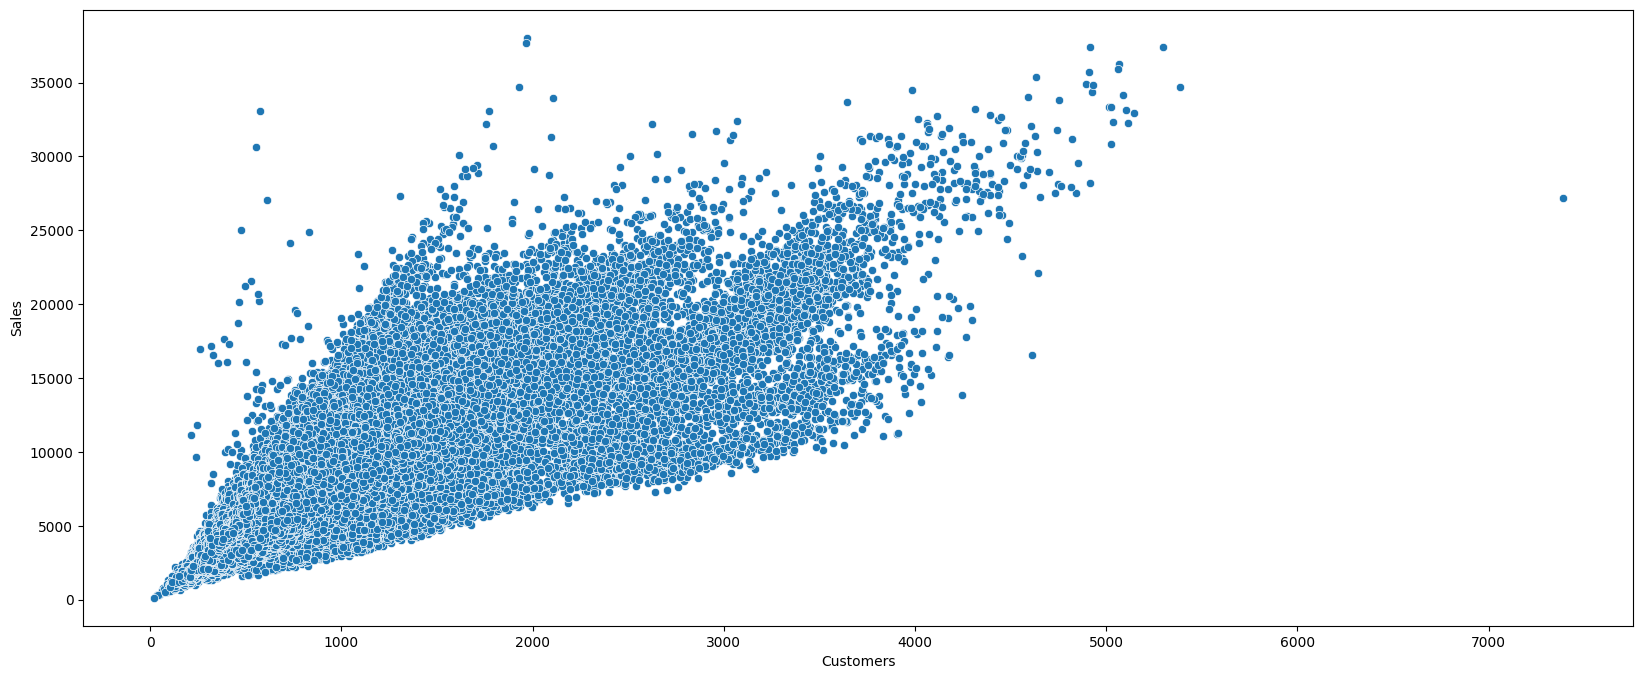

In [33]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x="Customers", y="Sales", data=train_store)
plt.show()

`Customers` cannot be used to predict the next day without knowing the number of customers!

# Open

In [34]:
print_NA_info(train_store, "Open")

Number of unique values: 2
Unique values: [ 1. nan]
Shape train data: (497376, 18)
The percentage of NA is: 3.02%


In [35]:
(
    train_store
    .groupby("Open")["Open"]
    .value_counts()
)

Open
1.0    482366
Name: count, dtype: int64

We drop `Open` because it does not add additional info (when the store is close the sales are 0, when it's open this variable does not add useful info)

# Promo

In [36]:
print_NA_info(train_store, "Promo")

Number of unique values: 3
Unique values: [ 0.  1. nan]
Shape train data: (497376, 18)
The percentage of NA is: 3.02%


In [37]:
a1 = mean_encode_2(train_store, "Promo", "Store", "Sales")
a1.loc[:, ["Promo", "Store", "PromoStore_mean"]].head(5)

,Promo,Store,PromoStore_mean
0,0.0,1115.0,5047.812245
1,0.0,1115.0,5047.812245
2,0.0,1115.0,5047.812245
3,0.0,1115.0,5047.812245
4,1.0,1115.0,6835.252577


In [38]:
a1 = (
    train_store
    .groupby(["Promo", "Store"])
    .agg(mean=("Sales", np.mean))
    .reset_index()
    .pivot(index='Store', columns="Promo", values="mean")
    .rename(columns={0.0:"0", 1.0:"1"})
)

a1["diff"] = a1["1"] - a1["0"]

a1.head(5)

Promo,0,1,diff
Store,,,
1.0,4313.866397,5390.953368,1077.086971
2.0,3846.047809,6237.675393,2391.627584
3.0,5370.272000,8942.585106,3572.313106
4.0,8656.483871,10435.390625,1778.906754
5.0,3504.456000,6117.279793,2612.823793


For each store, how much the `Promo=1` add to the mean Sales compared to when `Promo=0`

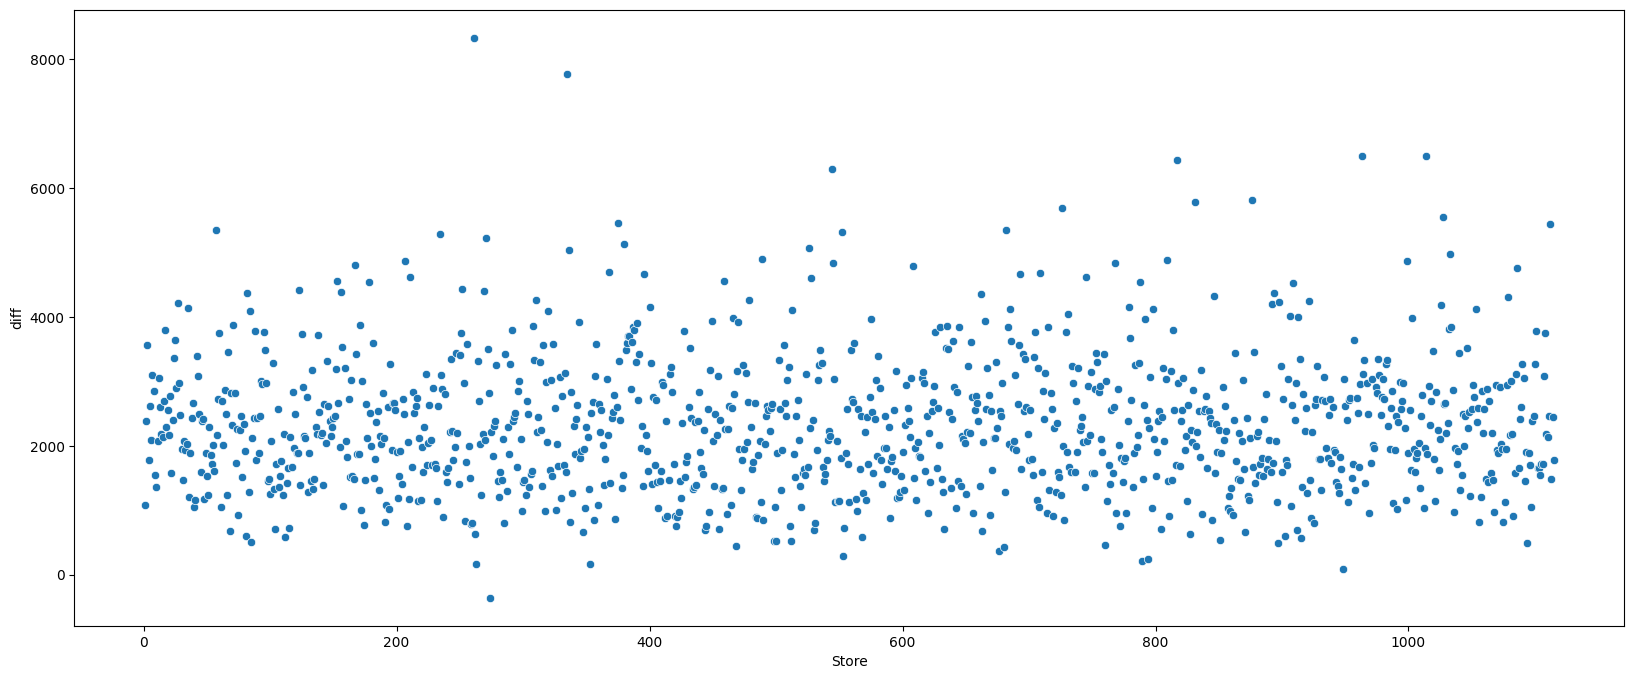

In [39]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x="Store", y="diff", data=a1)
plt.show()

# StateHoliday

- a = public holiday
- b = Easter holiday
- c = Christmas
- 0 = None

In [40]:
train_store.loc[train_store.StateHoliday==0.0, :] = "0"
train_store["StateHoliday"] = train_store.StateHoliday.astype("str")

In [41]:
print_NA_info(train_store, "StateHoliday")

Number of unique values: 5
Unique values: ['0' 'nan' 'a' 'b' 'c']
Shape train data: (497376, 18)
The percentage of NA is: 0.0%


# col

In [ ]:
train_store.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')